## <span style="color:#ff5f27;"> 📝 Imports</span>

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from hops import hdfs

project_path = hdfs.project_path()

project_path

'hdfs://rpc.namenode.service.consul:8020/Projects/electricity/'

## <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [3]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;">🧑🏻‍🏫 Functions</span>

In [4]:
def get_data(data_path):
    df = pd.read_csv(data_path,
        index_col = 0,
        parse_dates = ['date']
    ).dropna()
    
    return df    

def timestamp_2_time(x):
    dt_obj = datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
    dt_obj = dt_obj.timestamp() * 1000
    return dt_obj

def to_date(unix):
    return datetime.utcfromtimestamp(unix / 1000).strftime('%Y-%m-%d %H:%M:%S')

def feature_engineering(df):
    if type(df.date[0]) == np.int64:
        df.date = pd.to_datetime(df.date.apply(to_date))
    df['day_of_week'] = df.date.dt.dayofweek
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['month'] = df.date.dt.month
    df['quarter'] = df.date.dt.quarter
    df['year'] = df.date.dt.year
    df.date = df.date.apply(lambda x: timestamp_2_time(str(x)[:19])).astype(np.int64)
    
    return df


def create_feature_group(data = None,name='weather_fg',fs=fs):
    import great_expectations as ge
    
    expectation_suite = ge.core.ExpectationSuite(
        expectation_suite_name="Expectation Suite for Weather Feature Group"
    )
    
    expectation = ge.core.ExpectationConfiguration(
        expectation_type="expect_column_max_to_be_between",
        kwargs={
            "column": "min_temperature",
            "min_value": -30,
            "max_value": 30
        }
    )
    expectation_suite.add_expectation(expectation)
    
    feature_group = fs.get_or_create_feature_group(
        name=name,
        description = 'Daily weather conditions',
        version = 1,
        primary_key = ['index'],
        online_enabled = True,
        event_time = ['date'],
        expectation_suite=expectation_suite
    )
        
    feature_group.insert(data.reset_index())
    
    return feature_group


def retrieve_feature_group(name='weather_fg',fs=fs):
    feature_group = fs.get_feature_group(
        name=name,
        version=1
    )
    return feature_group

## <span style="color:#ff5f27;">🪄 👩🏻‍🔬 Retrieving or Creating Feature Group</span>

In [5]:
try:
    feature_group = retrieve_feature_group()
    df_weather = feature_group.read()
    indexes = df_weather.pop('index')
    
except: 
    DATA_PATH = project_path + 'Jupyter/data/weather.csv'
    
    df_weather = get_data(DATA_PATH)
    feature_engineering(df_weather)
    
    feature_group = create_feature_group(df_weather)

2022-08-22 08:07:28,048 INFO: USE `electricity_featurestore`
2022-08-22 08:07:28,766 INFO: SELECT `fg0`.`index` `index`, `fg0`.`date` `date`, `fg0`.`min_temperature` `min_temperature`, `fg0`.`max_temperature` `max_temperature`, `fg0`.`solar_exposure` `solar_exposure`, `fg0`.`rainfall` `rainfall`, `fg0`.`day_of_week` `day_of_week`, `fg0`.`day_of_month` `day_of_month`, `fg0`.`day_of_year` `day_of_year`, `fg0`.`week_of_year` `week_of_year`, `fg0`.`month` `month`, `fg0`.`quarter` `quarter`, `fg0`.`year` `year`
FROM `electricity_featurestore`.`weather_fg_1` `fg0`


In [6]:
df_weather.head()

,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,month,quarter,year
0,1583020800000,13.2,32.1,20.8,0.0,6,1,61,9,3,1,2020
1,1596240000000,5.7,16.4,11.1,0.0,5,1,214,31,8,3,2020
2,1536451200000,8.6,18.1,7.3,0.0,6,9,252,36,9,3,2018
3,1474848000000,8.1,16.9,13.6,0.6,0,26,270,39,9,3,2016
4,1420761600000,16.5,18.0,3.1,1.2,4,9,9,2,1,1,2015


## <span style="color:#ff5f27;">🕵🏻‍♂️ Data Exploration</span>

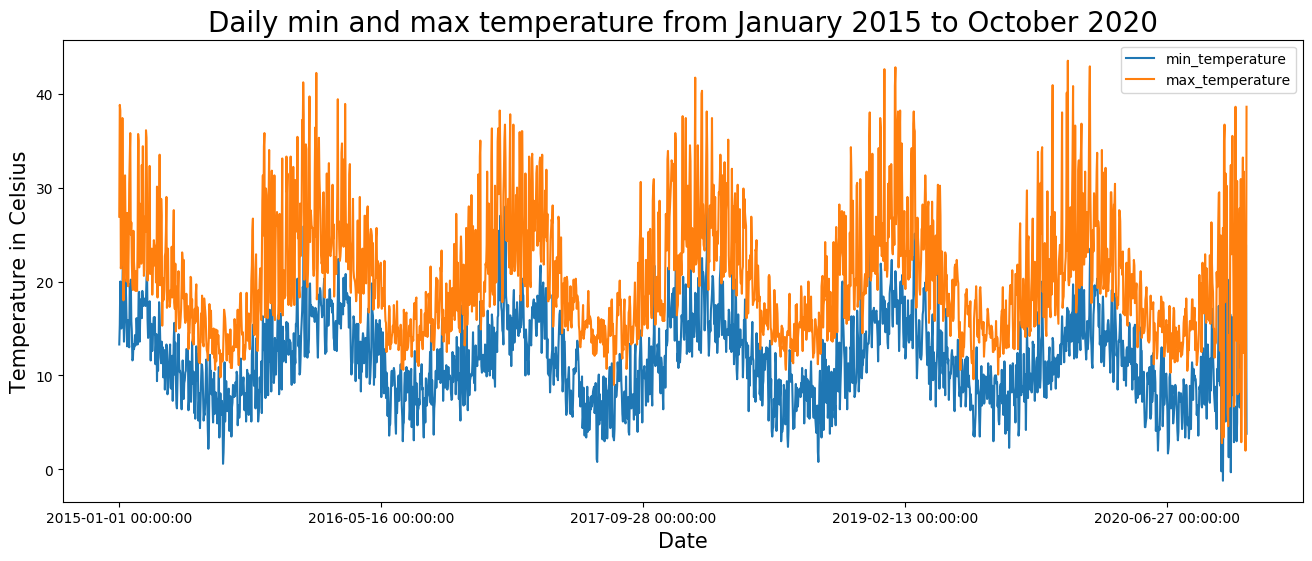

In [7]:
fig,ax = plt.subplots(figsize = (16,6))

df_plot = df_weather.sort_values('date')
df_plot.date = df_plot.date.apply(to_date)

df_plot.plot('date','min_temperature', ax = ax)
df_plot.plot('date','max_temperature', ax = ax)

ax.set_xlabel('Date',fontsize = 15)
ax.set_ylabel('Temperature in Celsius',fontsize = 15)
ax.set_title('Daily min and max temperature from January 2015 to October 2020',fontsize = 20)

plt.show()

## <span style="color:#ff5f27;">🧬 Data Generation</span>

In [8]:
def get_statistics(feature):
    mean = feature.mean()
    lower_value,upper_value = mean - feature.std() * 3,mean + feature.std() * 3
    return lower_value,upper_value

In [9]:
statistics = {col:get_statistics(df_weather[col]) for col in df_weather.columns[1:]}

date_window = 24*60*60*1000

In [10]:
def generate_observation(statistics):
    return [round(random.uniform(lower_value, upper_value),1) for lower_value, upper_value in statistics.values()]

def generate_data(df,amount = 1,date_window = date_window,statistics=statistics):
    df_last = df.sort_values('date').date.iloc[-1]
    df_generated = pd.DataFrame(columns = ['date',*statistics.keys()])
    for i in range(1, amount + 1):
        df_generated.loc[len(df_generated)] = [df_last + date_window * i,*generate_observation(statistics)]
    return df_generated.astype({'date':int})

def append_generated_data(df,amount = 1,date_window = date_window,statistics=statistics):
    df_last = df.sort_values('date').date.iloc[-1]
    for i in range(1, amount + 1):
        df.loc[len(df)] = [df_last + date_window,*generate_observation(statistics)]
    df.date = df.date.apply(int)
    return df

In [11]:
append_generated_data(df_weather,50)

df_weather.tail()

,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,month,quarter,year
2197,1606435200000,6.0,33.9,9.8,1.2,4.0,28.4,492.0,34.0,5.7,1.1,2021.0
2198,1606435200000,19.1,37.9,25.0,0.5,7.7,16.4,41.8,20.2,7.2,1.1,2015.4
2199,1606435200000,1.5,37.2,4.3,14.5,7.9,36.3,-120.1,16.8,13.8,1.9,2015.3
2200,1606435200000,10.9,9.8,34.9,10.0,8.6,6.6,304.1,-7.8,5.3,5.4,2020.1
2201,1606435200000,20.9,4.8,4.8,2.5,7.6,35.7,391.7,6.8,16.2,2.9,2019.8


## <span style="color:#ff5f27;">👩🏻‍⚖️ 🪄 Validation and Insertion of Generated Data</span>

In [12]:
def add_indexes(df,indexes=None):
    if indexes is None:
        return df.reset_index()
    df.reset_index(inplace = True)
    df['index'] = df['index'] + indexes.max() + 1
    return df

In [13]:
generated_data = generate_data(df_weather,50)
feature_engineering(generated_data)

try: 
    generated_data = add_indexes(generated_data,indexes)
except:
    generated_data = add_indexes(generated_data)

generated_data.head()

,index,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,month,quarter,year
0,2106,1606521600000,0.3,8.8,10.5,13.1,5,28,333,48,11,4,2020
1,2107,1606608000000,8.9,28.8,38.9,4.3,6,29,334,48,11,4,2020
2,2108,1606694400000,3.0,6.5,14.9,1.6,0,30,335,49,11,4,2020
3,2109,1606780800000,18.5,29.4,-5.1,10.1,1,1,336,49,12,4,2020
4,2110,1606867200000,14.8,20.8,-5.3,7.5,2,2,337,49,12,4,2020


In [14]:
feature_group.insert(generated_data)

2022-08-22 08:07:31,164 INFO: 	1 expectation(s) included in expectation_suite.
Validation Report saved successfully, explore a summary at https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/fs/68/fg/4110


Uploading Dataframe: 0.00% |          | Rows 0/50 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/jobs/named/weather_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7f3239ce1880>,
 {
   "evaluation_parameters": {},
   "meta": {
     "great_expectations_version": "0.14.3",
     "expectation_suite_name": "Expectation Suite for Weather Feature Group",
     "run_id": {
       "run_time": "2022-08-22T08:07:31.164304+00:00",
       "run_name": null
     },
     "batch_kwargs": {
       "ge_batch_id": "788c04ea-21f1-11ed-84ee-3e12410945e9"
     },
     "batch_markers": {},
     "batch_parameters": {},
     "validation_time": "20220822T080731.164179Z",
     "expectation_suite_meta": {
       "great_expectations_version": "0.14.3"
     }
   },
   "results": [
     {
       "result": {
         "observed_value": 24.6,
         "element_count": 50,
         "missing_count": null,
         "missing_percent": null
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       },
       "meta": {},
       "success": true,
       "expectation_config